# Customer Segmentation

## Installation

In [1]:
!pip3 install --user --upgrade google-cloud-aiplatform \
                                google-cloud-storage \
                                'google-cloud-bigquery[pandas]' \
                                category_encoders \
                                seaborn \
                                scikit-learn \
                                pandas \
                                fsspec \
                                gcsfs -q 


## Set up 
### Set up your Google Cloud project

In [2]:
PROJECT_ID = "my-ds-playground"

# !gcloud config set project {PROJECT_ID}

### Set up your Cloud Storage Bucket

In [3]:
REGION = "us-central1"
BUCKET_URI = "gs://my-ds-playground-customers-segmentation"

! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://my-ds-playground-customers-segmentation/...


### Initialize Vertex AI SDK for Python

In [4]:
from google.cloud import aiplatform

# Initialize the Vertex AI SDK
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

### Initialize BigQuery Client

In [5]:
from google.cloud import bigquery

bq_client = bigquery.Client(project=PROJECT_ID)

## Data Preparation

In [6]:
import numpy as np
import pandas as pd

BQ_SOURCE = "my-ds-playground.superstore.public_orders"
# NA_VALUES = ["NA", "."]

table = bq_client.get_table(BQ_SOURCE)
df = bq_client.list_rows(table).to_dataframe()
df.head(5)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,...,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,datastream_metadata
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,{'uuid': 'ea88a438-2c1d-4cbf-b29c-fccc00000000...
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,{'uuid': 'ea88a438-2c1d-4cbf-b29c-fccc00000000...
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,{'uuid': 'ea88a438-2c1d-4cbf-b29c-fccc00000000...
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,{'uuid': 'ea88a438-2c1d-4cbf-b29c-fccc00000000...
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,{'uuid': 'ea88a438-2c1d-4cbf-b29c-fccc00000000...


### Data Cleansing

In [7]:
df.isna().sum()

Row_ID                 0
Order_ID               0
Order_Date             0
Ship_Date              0
Ship_Mode              0
Customer_ID            0
Customer_Name          0
Segment                0
Country                0
City                   0
State                  0
Postal_Code            0
Region                 0
Product_ID             0
Category               0
Sub_Category           0
Product_Name           0
Sales                  0
Quantity               0
Discount               0
Profit                 0
datastream_metadata    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Row_ID               9994 non-null   Int64  
 1   Order_ID             9994 non-null   object 
 2   Order_Date           9994 non-null   object 
 3   Ship_Date            9994 non-null   object 
 4   Ship_Mode            9994 non-null   object 
 5   Customer_ID          9994 non-null   object 
 6   Customer_Name        9994 non-null   object 
 7   Segment              9994 non-null   object 
 8   Country              9994 non-null   object 
 9   City                 9994 non-null   object 
 10  State                9994 non-null   object 
 11  Postal_Code          9994 non-null   Int64  
 12  Region               9994 non-null   object 
 13  Product_ID           9994 non-null   object 
 14  Category             9994 non-null   object 
 15  Sub_Category         9994 non-null   o

In [9]:
orders_df = df.copy()
orders_df["Order_Date"] = pd.to_datetime(orders_df["Order_Date"])
orders_df["Ship_Date"] = pd.to_datetime(orders_df["Ship_Date"])
orders_df["Postal_Code"] = orders_df["Postal_Code"].astype(str)

### Feature Engineering

In [10]:
orders_df["Discount_Amount"] = orders_df["Sales"] * orders_df["Discount"]

In [11]:
main_df = orders_df.groupby(by="Customer_ID", as_index=False).agg({
    "Order_Date": "max",
    "Ship_Mode": (lambda x: x.mode()[0]),
    "Segment": (lambda x: x.mode()[0]),
    "Category": (lambda x: x.mode()[0]),
    "Region": (lambda x: x.mode()[0]),
    "Order_ID": "nunique",
    "Sales": "sum",
    "Discount_Amount": "sum"
})
main_df.head(5)

,Customer_ID,Order_Date,Ship_Mode,Segment,Category,Region,Order_ID,Sales,Discount_Amount
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720


In [12]:
main_df.columns = ["customer_id", "max_order_timestamp", "ship_mode", "type_customers", "category", "region", "frequency", "monetary", "discount"]
main_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720


In [13]:
main_df["max_order_timestamp"] = pd.to_datetime(main_df["max_order_timestamp"])
main_df["max_order_timestamp"] = main_df["max_order_timestamp"].dt.date
recent_date = orders_df["Order_Date"].dt.date.max()
main_df["recency"] = main_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

main_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415


## Exploratory Data Analysis

In [14]:
main_df.describe(include="all")

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency
count,793,793,793,793,793,793,793.000000,793.000000,793.000000,793.000000
unique,793,300,4,3,3,4,NaN,NaN,NaN,NaN
top,AA-10315,2017-12-02,Standard Class,Consumer,Office Supplies,East,NaN,NaN,NaN,NaN
freq,1,14,575,409,704,254,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.316520,2896.848500,406.787055,146.802018
std,NaN,NaN,NaN,NaN,NaN,NaN,2.550885,2628.670117,632.372871,186.211051
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,4.833000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,1146.050000,102.691200,30.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,2256.394000,247.915600,75.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3785.276000,491.433300,183.000000


array([[<Axes: title={'center': 'frequency'}>,
        <Axes: title={'center': 'monetary'}>],
       [<Axes: title={'center': 'discount'}>,
        <Axes: title={'center': 'recency'}>]], dtype=object)

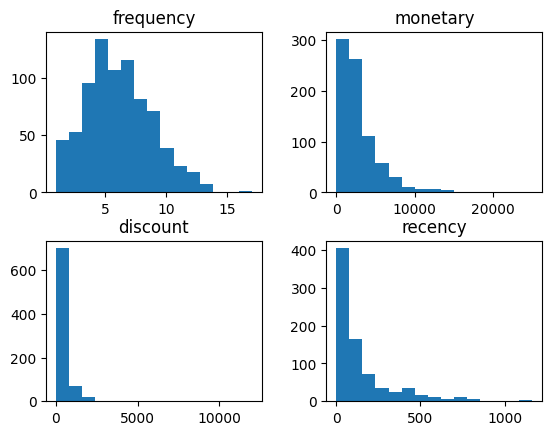

In [15]:
numerical = ["frequency", "monetary", "discount", "recency"]
main_df[numerical].hist(bins=15, grid=False)

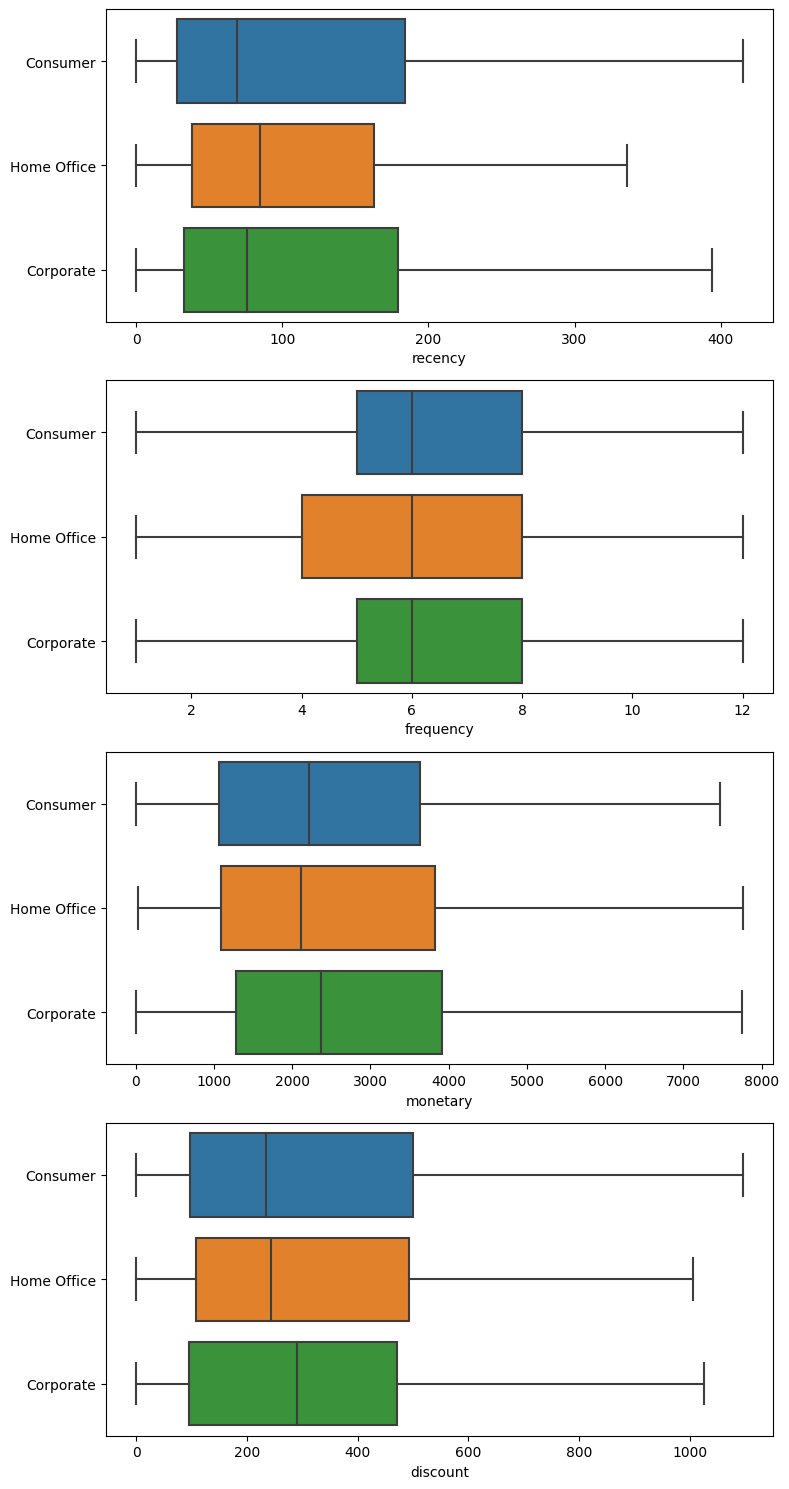

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def numerical_dis_plot(features, df, segment_feature=None, showfliers=False):
    fig, ax = plt.subplots(len(features), 1,figsize=(8,15))
    for i, feature in enumerate(features):
        if segment_feature:
            sns.boxplot(y=segment_feature, x=feature, data=df, ax=ax[i], showfliers=showfliers)
            ax[i].set_ylabel(None)
        else:
            sns.boxplot(x=feature, data=df, ax=ax[i], showfliers=showfliers)
    plt.tight_layout()
    plt.show()

numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=main_df, 
    segment_feature="type_customers"
)

## Modelling

In [17]:
kmeans_df = main_df[["customer_id", "recency", "frequency", "monetary", "discount"]]
kmeans_df.head(5)

,customer_id,recency,frequency,monetary,discount
0,AA-10315,184,5,5563.560,1015.92800
1,AA-10375,19,9,1056.390,34.54400
2,AA-10480,259,4,1790.512,3.11040
3,AA-10645,55,6,5086.935,532.18395
4,AB-10015,415,3,886.156,12.26720


In [18]:
from sklearn.preprocessing import PowerTransformer
import joblib

def power_transforms(features, df):
  df = df[features]
  for feature in features:
    transformer = PowerTransformer(standardize=True)
    y = np.asanyarray(df[feature])
    y = y.reshape(-1,1)
    transformer.fit(y)
    df["transform_{}".format(feature)] = transformer.transform(y)
    df.drop([feature], axis=1, inplace=True)
    joblib.dump(transformer, "transformer_{}.joblib".format(feature))
  return df

In [19]:
transformed_kmeans_df = power_transforms(
    features=["recency", "frequency", "monetary", "discount"],
    df=kmeans_df
)
transformed_kmeans_df.head()

,transform_recency,transform_frequency,transform_monetary,transform_discount
0,0.701552,-0.459931,1.142958,1.325414
1,-0.994117,1.046277,-0.719477,-1.177057
2,0.996872,-0.893752,-0.220629,-1.993385
3,-0.257312,-0.053650,1.018462,0.675151
4,1.422079,-1.363189,-0.869587,-1.602655


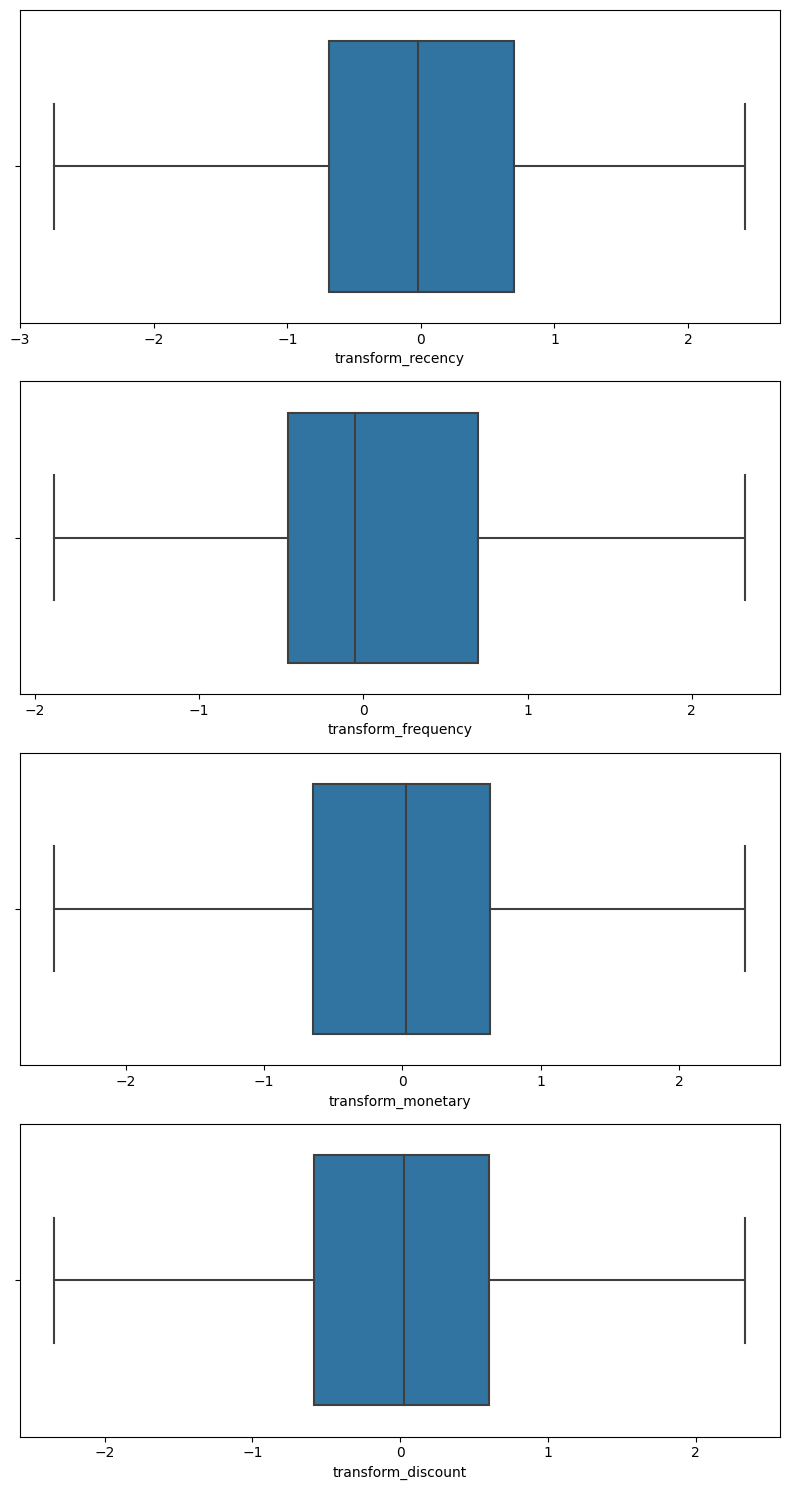

In [20]:
numerical_dis_plot(
    features=["transform_recency", "transform_frequency", "transform_monetary", "transform_discount"],
    df=transformed_kmeans_df,
)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

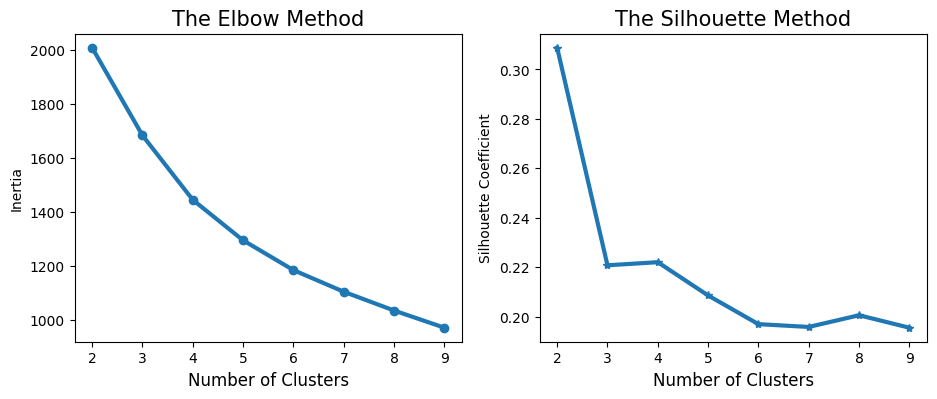

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = {}
silhouette = {}

for k in range(2,10):
    model = KMeans(n_clusters = k, random_state=75)
    model.fit_predict(transformed_kmeans_df)
    inertia[k]= model.inertia_ # Calculate the inertia
    silhouette[k]= silhouette_score(transformed_kmeans_df, model.labels_) # Calculate the silhouette coefficient

fig, axs = plt.subplots(1,2, figsize = (11,4))
axs[0].plot(inertia.keys(), inertia.values(), marker = 'o', lw = 3)
axs[0].set_xlabel('Number of Clusters', fontsize = 12)
axs[0].set_ylabel('Inertia')
axs[0].set_title('The Elbow Method', fontsize = 15)

axs[1].plot(inertia.keys(), silhouette.values(), marker = '*' , lw = 3)
axs[1].set_xlabel('Number of Clusters', fontsize = 12)
axs[1].set_ylabel('Silhouette Coefficient')
axs[1].set_title('The Silhouette Method', fontsize = 15)
plt.show()

In [43]:
K = 4

model = KMeans(n_clusters=K, random_state=75)
model.fit(transformed_kmeans_df)

joblib.dump(model, "model.joblib")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


['model.joblib']

In [44]:
clusters = model.predict(transformed_kmeans_df)

kmeans_df["customer_segment"] = clusters.astype(str)
kmeans_df.sample(5)

/var/tmp/ipykernel_38158/1114921852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_df["customer_segment"] = clusters.astype(str)


,customer_id,recency,frequency,monetary,discount,customer_segment
382,JK-16120,117,10,2932.484,543.82000,0
431,KH-16630,58,9,3918.966,261.59520,0
520,ML-17410,54,6,2921.500,554.19320,2
618,RA-19915,12,9,4793.543,940.26155,0
344,JC-15340,114,4,71.263,7.47410,3


## Save the model to a Cloud Storage path

In [27]:
from google.cloud import storage

BUCKET_NAME = "my-ds-playground-customers-segmentation"
MODEL_NAME = "model.joblib"


bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(MODEL_NAME)
blob.upload_from_filename(MODEL_NAME)

## Create a Vertex AI model 

In [28]:
MODEL_DISPLAY_NAME = "kmeans_clustering_model"
ARTIFACT_GCS_PATH = "gs://my-ds-playground-customers-segmentation"
exp_metadata = {"inputs": {"Inp_feature": {}}, "outputs": {"Model_output": {}}}

In [29]:
from google.cloud import aiplatform
from google.cloud.aiplatform_v1.types import SampledShapleyAttribution
from google.cloud.aiplatform_v1.types.explanation import ExplanationParameters

In [30]:
# aiplatform.init(project=PROJECT_ID, location=REGION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-2:latest",
    # explanation_metadata=exp_metadata,
    # explanation_parameters=ExplanationParameters(
    #     sampled_shapley_attribution=SampledShapleyAttribution(path_count=25)
    # ),
)

model.wait()

print(model.display_name)
print(model.resource_name)

kmeans_clustering_model
projects/107871909349/locations/us-central1/models/5947221011245039616


## Create an Endpoint

In [31]:
ENDPOINT_DISPLAY_NAME = "customers_segmentation"

endpoint = aiplatform.Endpoint.create(
    display_name=ENDPOINT_DISPLAY_NAME, project=PROJECT_ID, location=REGION
)

print(endpoint.display_name)
print(endpoint.resource_name)

customers_segmentation
projects/107871909349/locations/us-central1/endpoints/9202052506392199168


## Deploy the Model to the Created Endpoint

In [32]:
DEPLOYED_MODEL_NAME = "customers_segmentation_deployment"
MACHINE_TYPE = "n1-standard-4"

model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print(model.display_name)
print(model.resource_name)

kmeans_clustering_model
projects/107871909349/locations/us-central1/models/5947221011245039616


In [33]:
endpoint.list_models()

[id: "1923399879724367872"
 model: "projects/107871909349/locations/us-central1/models/5947221011245039616"
 display_name: "customers_segmentation_deployment"
 create_time {
   seconds: 1693376253
   nanos: 488656000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-4"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 model_version_id: "1"]

## Make an Online Prediction Request

In [46]:
kmeans_df.iloc[10].drop(["customer_id", "customer_segment"])

recency            50
frequency           4
monetary     1515.862
discount     377.2034
Name: 10, dtype: object

In [47]:
# kmeans_df.iloc[10].pop(["customer_id", "customer_segment"])

In [52]:
data = kmeans_df.iloc[344].drop(["customer_id", "customer_segment"])
data = [data.astype("float32").tolist()]

predictions = endpoint.predict(instances=data)
y_predicted = predictions.predictions[0]
print("customer_segment:", y_predicted)

customer_segment: 1.0
